In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install pyreadstat
# !pip install --upgrade pandas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core.embedding import Embedding
from keras.layers import Dense, Dropout, Input, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(124)
tf.config.experimental.enable_op_determinism()

(208, 65)


<Axes: >

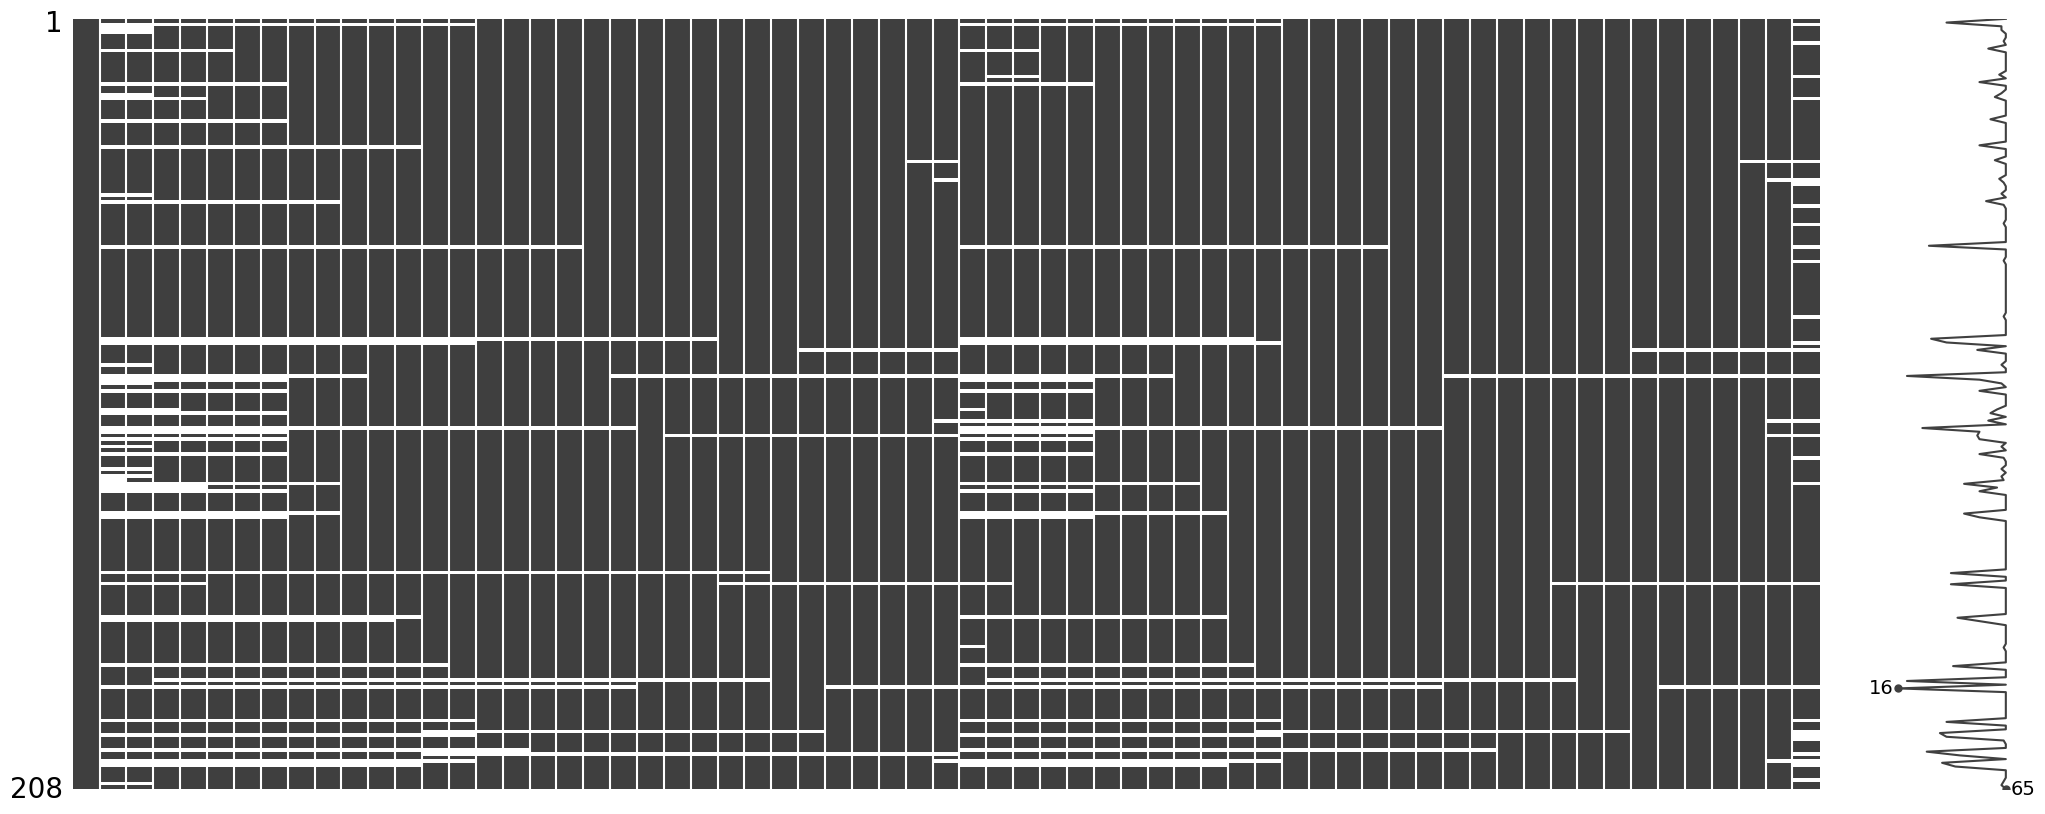

In [3]:
# 데이터 불러오기
df_growth = pd.read_excel("/content/drive/MyDrive/경제성장률, 1990-2021.xlsx")
df_gdp= pd.read_excel("/content/drive/MyDrive/국내총생산(당해년가격), 1990-2021.xlsx")

# 데이터 합치기
df=pd.merge(df_growth,df_gdp, on='국가별')
print(df.shape) # (208, 65)

# 결측치 보기
msno.matrix(df)

In [4]:
# # *데이터 전처리
# df = df.drop(['국가별'], axis=1)

# 행열 전환
df=df.transpose()
df.shape

(65, 208)

In [5]:
df

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
국가별,대한민국,아프가니스탄,아르메니아,아제르바이잔,바레인,방글라데시,부탄,브루나이,캄보디아,중국,...,뉴칼레도니아,뉴질랜드,북마리아나제도,팔라우,파푸아뉴기니,사모아,솔로몬제도,통가,투발루,바누아투
1990_x,7.1,NaN,NaN,NaN,0.4,2.8,7.4,-1.1,NaN,4.2,...,11.0,0.2,NaN,NaN,-1.4,3.7,4.3,0.4,NaN,1.5
1991_x,9.9,NaN,NaN,NaN,4.4,5.6,10.4,1.1,NaN,3.9,...,3.6,0.2,NaN,NaN,-3.0,-4.4,2.2,-2.0,NaN,11.7
1992_x,10.8,NaN,-11.7,-0.7,11.2,3.5,-0.4,3.1,NaN,9.3,...,4.9,-1.1,NaN,NaN,9.5,-2.3,6.0,6.4,3.6,3.1
1993_x,6.2,NaN,-41.8,-22.6,6.7,5.4,4.6,4.8,NaN,14.2,...,0.5,1.1,NaN,NaN,13.8,-0.2,12.7,0.3,2.8,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017_y,1623.3,18.8,11.5,40.9,35.5,293.8,2.5,12.1,22.2,12310.4,...,9.2,206.6,1.6,0.3,22.7,0.8,1.5,0.5,0.0,0.9
2018_y,1725.2,18.1,12.5,47.1,37.8,321.4,2.4,13.6,24.6,13894.8,...,9.8,212.0,1.3,0.3,24.1,0.8,1.6,0.5,0.0,0.9
2019_y,1651.0,18.8,13.6,48.2,38.7,351.2,2.5,13.5,27.1,14279.9,...,9.4,213.4,1.2,0.3,24.8,0.9,1.6,0.5,0.1,0.9
2020_y,1644.6,20.1,12.6,42.7,34.7,373.9,2.3,12.0,25.9,14687.7,...,9.4,211.7,NaN,0.3,24.7,0.8,1.5,0.5,0.1,0.9


In [6]:
# 결측치
# 나라별 50% 이상 결측치 삭제
df_del_col=df.columns [df.isnull().sum() > 0.5 * len(df)]
print(df_del_col)
df = df.drop(columns=df_del_col)

# 데이터 나눠서 나라별 50% 이하 결측치 대체
imputer = SimpleImputer(strategy='median')
print(df.shape)
df1=df.iloc[1:33,:]
df2=df.iloc[33:,:]

df1 = pd.DataFrame(imputer.fit_transform(df1), columns=df1.columns, index=df1.index)
df2 = pd.DataFrame(imputer.fit_transform(df2), columns=df2.columns, index=df2.index)
print(df1)
print(df2)

Int64Index([61, 86, 96, 110, 178, 180, 197], dtype='int64')
(65, 201)
         0     1      2     3     4    5     6    7     8     9    ...    198  \
1990_x   7.1   3.9   5.65   3.9   0.4  2.8   7.4 -1.1   7.1   4.2  ...  11.00   
1991_x   9.9   3.9   5.65   3.9   4.4  5.6  10.4  1.1   7.1   3.9  ...   3.60   
1992_x  10.8   3.9 -11.70  -0.7  11.2  3.5  -0.4  3.1   7.1   9.3  ...   4.90   
1993_x   6.2   3.9 -41.80 -22.6   6.7  5.4   4.6  4.8   7.1  14.2  ...   0.50   
1994_x   6.9   3.9  -8.80 -23.1  12.9  4.7   2.0  0.3   7.1  13.9  ...   0.50   
1995_x   9.3   3.9   5.40 -19.7  -0.3  3.9   5.0  3.1 -34.8  13.0  ...   2.60   
1996_x   9.6   3.9   6.90 -11.8   3.9  5.1   7.1  4.5   9.9  11.0  ...   5.90   
1997_x   7.9   3.9   5.90   1.3   4.1  4.5   5.6  2.9   5.9   9.9  ...   0.40   
1998_x   6.2   3.9   3.30   5.8   3.1  4.5   5.4 -1.5   4.0   9.2  ...   2.00   
1999_x  -5.1   3.9   7.30  10.0   4.8  5.2   5.9 -0.6   4.7   7.8  ...  -3.20   
2000_x  11.5   3.9   3.30   7.4   4.3  

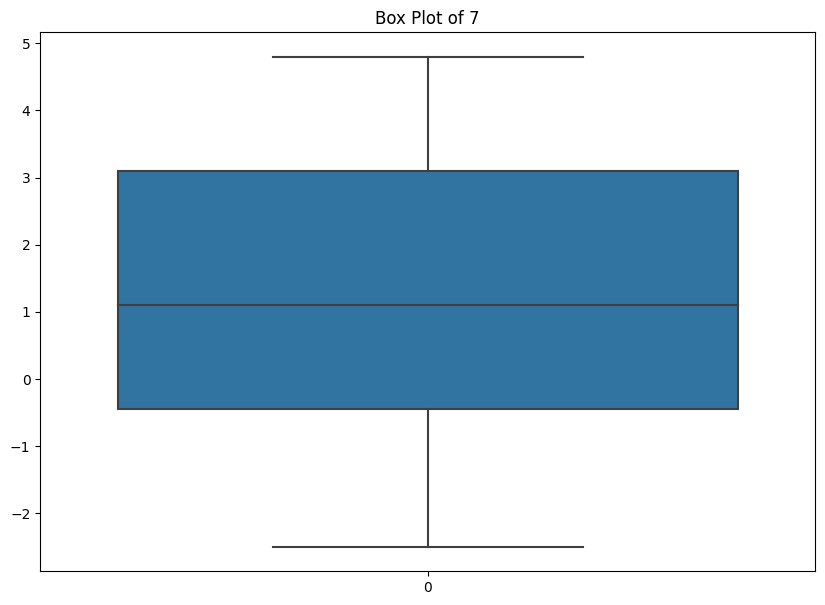

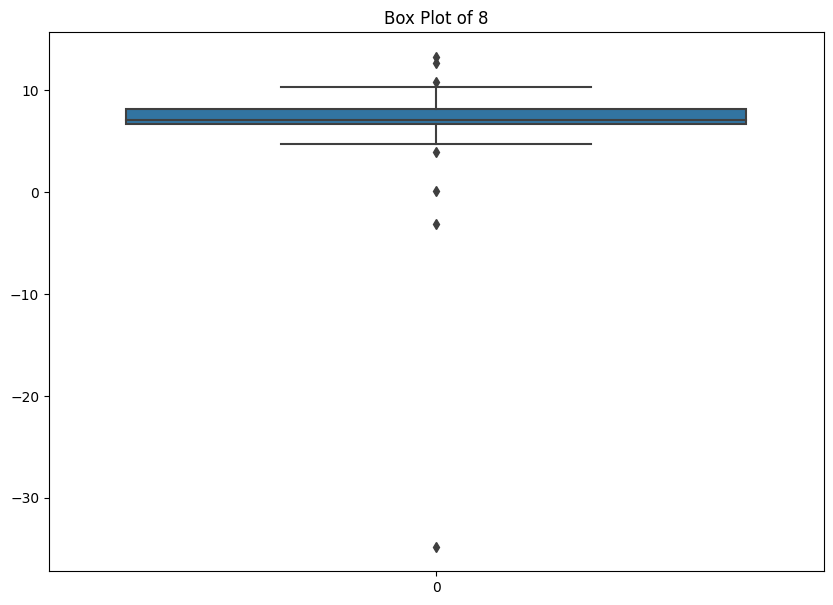

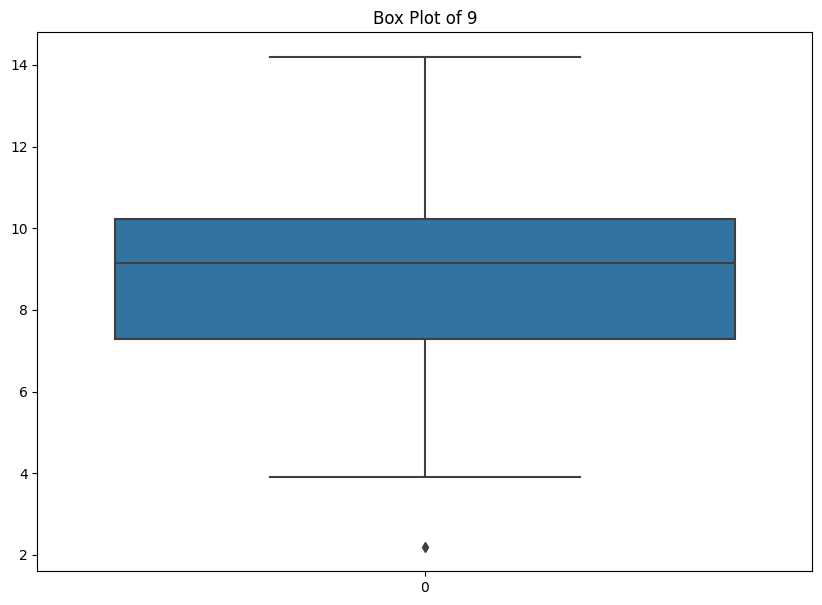

In [7]:
# 이상치
# 일단 3개 칼럼만 보기->이상치 존재
for country in range(7, 10): 
    column_name = country
    plt.figure(figsize=(10, 7))
    sns.boxplot(data=df1[column_name])
    plt.title(f'Box Plot of {column_name}')
    plt.show()

In [8]:
#df 1 이상치 제거-안함(경제성장률)
country = df1.columns.tolist()
for column_name in country:
    Q1 = df1[column_name].quantile(0.25)
    Q3 = df1[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df1[(df1[column_name] < lower_bound) | (df1[column_name] > upper_bound)][column_name]

    # 이상치 삭제
    # index = df1[(df1[column_name] < lower_bound) | (df1[column_name] > upper_bound)].index
    # print(index): 삭제하기에는 너무 많음
    # 이상치를 중앙값으로 대체
    # outliers = df1[(df1[column_name] < lower_bound) | (df1[column_name] > upper_bound)][column_name]
    # df1.loc[df1[column_name].isin(outliers), column_name] = df1[column_name].median()

In [9]:
print(df1)
print(df2)

         0     1      2     3     4    5     6    7     8     9    ...    198  \
1990_x   7.1   3.9   5.65   3.9   0.4  2.8   7.4 -1.1   7.1   4.2  ...  11.00   
1991_x   9.9   3.9   5.65   3.9   4.4  5.6  10.4  1.1   7.1   3.9  ...   3.60   
1992_x  10.8   3.9 -11.70  -0.7  11.2  3.5  -0.4  3.1   7.1   9.3  ...   4.90   
1993_x   6.2   3.9 -41.80 -22.6   6.7  5.4   4.6  4.8   7.1  14.2  ...   0.50   
1994_x   6.9   3.9  -8.80 -23.1  12.9  4.7   2.0  0.3   7.1  13.9  ...   0.50   
1995_x   9.3   3.9   5.40 -19.7  -0.3  3.9   5.0  3.1 -34.8  13.0  ...   2.60   
1996_x   9.6   3.9   6.90 -11.8   3.9  5.1   7.1  4.5   9.9  11.0  ...   5.90   
1997_x   7.9   3.9   5.90   1.3   4.1  4.5   5.6  2.9   5.9   9.9  ...   0.40   
1998_x   6.2   3.9   3.30   5.8   3.1  4.5   5.4 -1.5   4.0   9.2  ...   2.00   
1999_x  -5.1   3.9   7.30  10.0   4.8  5.2   5.9 -0.6   4.7   7.8  ...  -3.20   
2000_x  11.5   3.9   3.30   7.4   4.3  4.7   8.0  3.1  12.7   7.7  ...   0.90   
2001_x   9.1   3.9   5.90  1

In [10]:
# train 데이터 생성 (gdp)
train = df2.iloc[:,:150] # 훈련

# test 데이터 생성 (gdp)
test= df2.iloc[:,150:]
print('train--------------------------')
print(train)
print('test--------------------------')
print(test)

train=train.transpose()
test=test.transpose()

# 데이터 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
print(train_scaled.shape) # (150, 32)

train--------------------------
           0     1     2     3     4      5    6     7     8        9    ...  \
1990_y   283.3  17.8   2.3   8.9   4.2   31.6  0.3   3.5   8.6    360.9  ...   
1991_y   330.5  17.8   2.1   8.8   4.6   31.0  0.2   3.7   8.6    383.4  ...   
1992_y   355.4  17.8   1.3   0.4   4.8   31.7  0.2   4.2   8.6    426.9  ...   
1993_y   392.6  17.8   1.2   1.6   5.2   33.2  0.2   4.1   2.5    444.7  ...   
1994_y   463.5  17.8   1.3   1.2   5.6   33.8  0.3   4.1   2.8    564.3  ...   
1995_y   566.8  17.8   1.5   2.4   5.8   37.9  0.3   4.7   3.4    734.5  ...   
1996_y   609.9  17.8   1.6   3.2   6.1   46.4  0.3   5.1   3.5    863.7  ...   
1997_y   569.9  17.8   1.6   4.0   6.3   48.2  0.4   5.2   3.4    961.6  ...   
1998_y   384.0  17.8   1.9   4.4   6.2   50.0  0.4   4.1   3.1   1029.0  ...   
1999_y   497.2  17.8   1.8   4.6   6.6   51.3  0.4   4.6   3.5   1094.0  ...   
2000_y   576.4  17.8   1.9   5.3   9.1   53.4  0.4   6.0   3.7   1211.3  ...   
2001_y  

In [11]:
# X, y 분리
def split_xy(dataset, time_steps, y_column):
    X, y = [], []
    for i in range(len(dataset)-time_steps+1):
        x = dataset[i:(i+time_steps), :]
        X.append(x)
        y.append(dataset[i+time_steps-1, y_column])
    return np.array(X), np.array(y)

time_steps = 3
y_column = 31
X_train, y_train = split_xy (train_scaled, time_steps, y_column)
X_test, y_test = split_xy (test_scaled, time_steps, y_column)
                     # (batch_size, timesteps, input_dim)인 3D 텐서
print(X_train.shape) # (148, 3, 32) 
print(y_train.shape) # (148,)

(148, 3, 32)
(148,)


In [12]:
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(3, 32)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dropout(0.2))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mse', optimizer='adam')

# *모델 학습 1
history = model.fit(X_train, y_train, epochs=100, batch_size=3, validation_split=0.2)

# 모델 저장
# model.save('my_model.h5')

# 모델 평가
loss = model.evaluate(X_test, y_test)

Epoch 1/100
40/40 [==============================] - 19s 40ms/step - loss: 0.0141 - val_loss: 0.0011
Epoch 2/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0138 - val_loss: 9.5585e-04
Epoch 3/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0128 - val_loss: 8.2829e-04
Epoch 4/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0126 - val_loss: 7.2954e-04
Epoch 5/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0115 - val_loss: 8.7232e-04
Epoch 6/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 3.4976e-04
Epoch 7/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 1.5706e-04
Epoch 8/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0057 - val_loss: 3.6305e-04
Epoch 9/100
40/40 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 1.7264e-04
Epoch 10/100
40/40 [==============================] - 0s 9ms/step - loss: 0

17/17 [==============================] - 0s 4ms/step - loss: 1.7989e-05
Test set MSE: 0.000018
2/2 [==============================] - 1s 7ms/step
Test set MAE: 0.007542
2/2 [==============================] - 0s 6ms/step
Test set R-squared: 0.821796
2/2 [==============================] - 0s 6ms/step


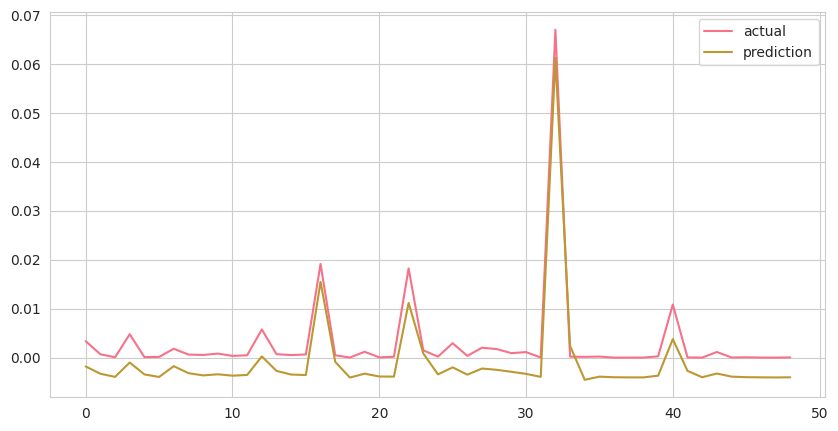

2/2 [==============================] - 0s 7ms/step


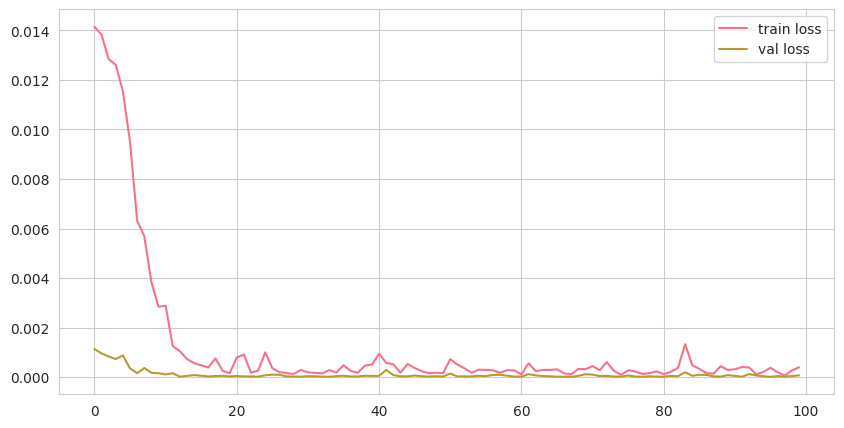

In [13]:
# 모델 평가
# mse
test_mse = model.evaluate(X_test, y_test, batch_size=3)
print(f"Test set MSE: {test_mse:.6f}")
# mae
test_mae = np.mean(np.abs(model.predict(X_test) - y_test))
print(f"Test set MAE: {test_mae:.6f}")
# r2
test_r2 = r2_score(y_test, model.predict(X_test))
print(f"Test set R-squared: {test_r2:.6f}")

# *시각화
# 실제값과 예측값
mpl.rcParams['figure.figsize'] = (10,5)
sns.set_style('whitegrid')
sns.set_palette('husl')
y_pred = model.predict(X_test)

plt.plot(y_test, label='actual')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()

# loss
y_pred = model.predict(X_test)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Epoch 1/100
40/40 [==============================] - 0s 9ms/step - loss: 2.7232e-04 - val_loss: 7.2187e-05
Epoch 2/100
40/40 [==============================] - 0s 9ms/step - loss: 3.4914e-04 - val_loss: 2.1816e-05
Epoch 3/100
40/40 [==============================] - 0s 12ms/step - loss: 1.4343e-04 - val_loss: 1.3806e-05
Epoch 4/100
40/40 [==============================] - 0s 11ms/step - loss: 1.7928e-04 - val_loss: 3.7245e-05
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 2.3560e-04 - val_loss: 3.7177e-05
Epoch 6/100
17/17 [==============================] - 0s 4ms/step - loss: 8.8976e-06
Test set MSE: 0.000009
2/2 [==============================] - 0s 8ms/step
Test set MAE: 0.005987
2/2 [==============================] - 0s 6ms/step
Test set R-squared: 0.911858
2/2 [==============================] - 0s 6ms/step


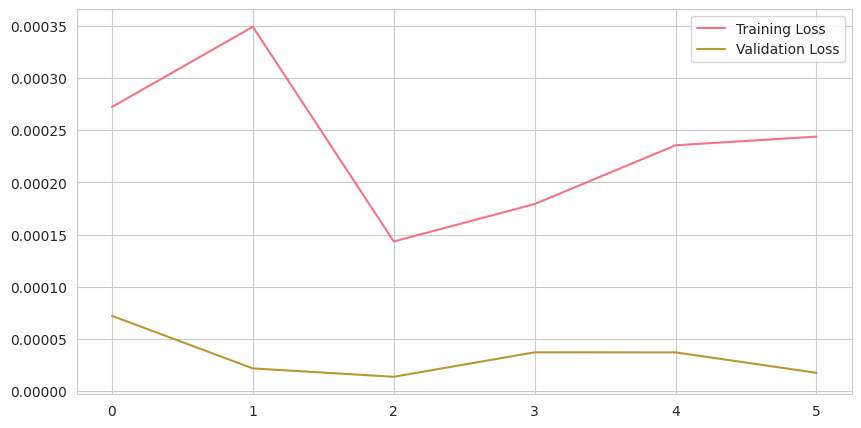

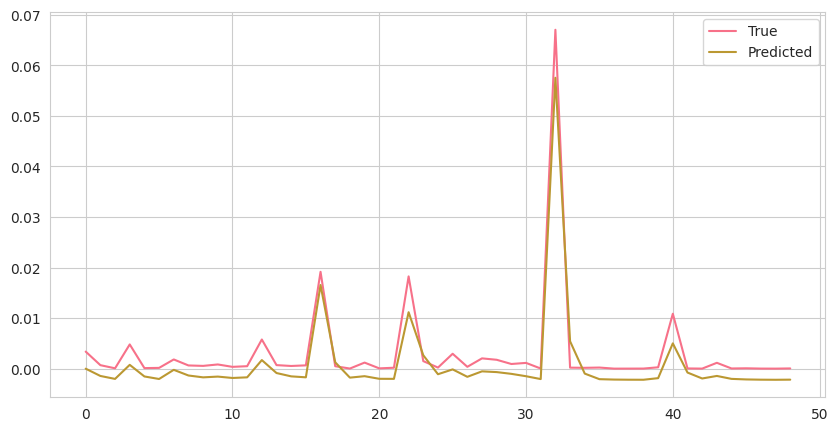

In [14]:
# *모델 학습 2
history = model.fit(X_train, y_train, epochs=100, batch_size=3, validation_split=0.2,
                    callbacks=[EarlyStopping(patience=3, monitor='val_loss')])
# 모델 평가
# mse
test_mse = model.evaluate(X_test, y_test, batch_size=3)
print(f"Test set MSE: {test_mse:.6f}")
# mae
test_mae = np.mean(np.abs(model.predict(X_test) - y_test))
print(f"Test set MAE: {test_mae:.6f}")
# r2
test_r2 = r2_score(y_test, model.predict(X_test))
print(f"Test set R-squared: {test_r2:.6f}")

# 결과 시각화
y_pred = model.predict(X_test)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()